# Evolutionary Algorithms for Combinatorial Multi-Knapsack
## EA Functions
### Imports and Config

In [30]:
import time, array, random, copy, math, sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from deap import algorithms, base, benchmarks, tools, creator
import seaborn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seaborn.set(style='whitegrid')
seaborn.set_context('notebook')
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

### Instance Creation

In [23]:
def ws_split_int(lst):
    lst = re.split(r'\s+', lst)
    lst.pop()        #remove first empty character
    lst.pop(0)       #remove last empty character
    lst = [int(x) for x in lst]
    return lst
def instance_create(file_name, m, pop_size, num_gen, mut_rate, xover_rate, sample_num):
    with open(file_name) as f:
        lines = f.readlines()
    d = dict();
    d['ref'] = lines[0].strip()
    num_of_vars = d['num_of_vars'] = int(lines[1])
    d['profits'] = np.asarray(ws_split_int(lines[2]))
    combinations = [ws_split_int(i) for i in lines[3:num_of_vars+2]]
    combi_length = max(map(len, combinations))
    d['combinations'] = np.array([[0]*(combi_length-len(xi))+xi for xi in combinations])
    d['constraint_type'] = lines[int(num_of_vars)+3]
    weights = np.asarray(ws_split_int(lines[num_of_vars+5]))
    d['weights'] = weights    
    d['capacity'] = math.floor((0.8 * sum(weights)) / m)
    d['mut_rate'] = mut_rate
    d['xover_rate'] = xover_rate
    d['num_gen'] = num_gen
    d['pop_size'] = pop_size
    d['n_kp'] = m
    return d


### Population Generation, Fitness, Mutation, and Xover

In [24]:
def eval_fitness(individual, instance):
    n_kp = instance.get("n_kp")
    num_of_vars = instance.get("num_of_vars")
    profits = instance.get("profits")
    combinations = instance.get("combinations")
    constraint_type = instance.get("constraint_type")
    capacity = int(instance.get("capacity"))
    weights = instance.get("weights")
    knapsacks_weight = [0]*n_kp
    knapsacks_profit = [0]*n_kp
    
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] <= n_kp:
            knapsack = individual[i] - 1
            knapsacks_weight[knapsack] += weights[i]
            knapsacks_profit[knapsack] += profits[i]
            for j in range(len(individual)):
                if knapsack == individual[j] - 1:
                    knapsacks_profit[knapsack] += combinations[i-1][j-1]
    f1 = 0
    f2 = sum(knapsacks_weight)
    f3 = max(knapsacks_profit)+1
    for i in range(n_kp):
        if knapsacks_weight[i] > capacity:
            temp = knapsacks_profit[i] * (capacity / knapsacks_weight[i])
        else:
            temp = knapsacks_profit[i]
        f1 += temp
        if temp < f3:
            f3 = temp
    return f1, f2, f3

def uniform(low, m, n_kp):
    n = [0]*m
    for i in range(0,m):
        n[i] = random.randint(0,n_kp)
    return n

def favorite_child_xover(ind1, ind2):
    fit1 = ind1.fitness.values
    fit2 = ind2.fitness.values
    
    prob = fit1[0] / (fit1[0]+fit2[0])
    
    if fit1[0] > fit2[0]:
        prob = 1/prob
    
    size = min(len(ind1), len(ind2))
    
    for i in range(size):
        if random.random() > prob:
            ind1[i] = ind2[i]
            ind2[i] = ind1[i]
    return ind1, ind2

def mutation(x, n_kp):
    index = random.randrange(len(x))
    var = random.randint(0,n_kp)
    x[index] = var
    return x,


### Running EA

In [25]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    population, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cx_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=True)
    return population, logbook

### Single Execution Script

In [33]:
def execute_EA(instance, verbose = False):
    creator.create("FitnessMin", base.Fitness, weights=(1.0,-1.0, 1.0))
    creator.create("Individual", list, typecode='i', 
                   fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    num_kp = instance.get("n_kp")
    toolbox.register("evaluate", lambda x: eval_fitness(x, instance))
    BOUND_LOW, BOUND_UP = 0, instance.get("num_of_vars")
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, num_kp)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", favorite_child_xover)
    toolbox.register("mutate", lambda x: mutation(x, num_kp),)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = instance.get("pop_size")
    toolbox.max_gen = instance.get("num_gen")
    toolbox.mut_prob = instance.get("mut_rate")
    toolbox.cx_prob = instance.get("xover_rate")
    if verbose: 
        res,logbook = run_ea(toolbox)
    else:
        with HiddenPrints():
            res,logbook = run_ea(toolbox)
    fronts = [tools.emo.sortLogNondominated(res, len(res), first_front_only=True)]
    plot_colors = seaborn.color_palette("Set1", n_colors=10)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    
    st_front = []
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df = df.rename(columns={0: "f1", 1: "f2", 2: "f3"})
        ax1.scatter3D(df.f1, df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax2.scatter(df.f1, df.f2, label='Front'+str(i+1), color=plot_colors[i])
        ax3.scatter(df.f1, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        ax4.scatter(df.f2, df.f3, label='Front'+str(i+1), color=plot_colors[i])
        st_front.append(df)
    ax1.legend();ax2.legend();ax3.legend();ax4.legend()
    ax1.set_xlabel('$f_1(\mathbf{x})$');ax1.set_ylabel('$f_2(\mathbf{x})$');ax1.set_zlabel('$f_3(\mathbf{x})$')
    ax2.set_xlabel('$f_1(\mathbf{x})$');ax2.set_ylabel('$f_2(\mathbf{x})$')
    ax3.set_xlabel('$f_1(\mathbf{x})$');ax3.set_ylabel('$f_3(\mathbf{x})$')
    ax4.set_xlabel('$f_2(\mathbf{x})$');ax4.set_ylabel('$f_3(\mathbf{x})$')
    stat_dict = {'instance_name': instance.get('ref'),
             'sample_num': instance.get('sample_num'),
             'xover_rate': instance.get('xover_rate'),
             'mut_rate': instance.get('mut_rate'),
             'pop_size': instance.get('pop_size'),
             'num_gen': instance.get('num_gen'),
             'n_kp': instance.get('n_kp'),
             'mean_f1' : np.mean(st_front[0].f1),
             'median_f1' : np.median(st_front[0].f1),
             'variance_f1': np.var(st_front[0].f1), 
             'sample_size': len(st_front[0].f1), 
             'min_f1': min(st_front[0].f1),
             'max_f1': max(st_front[0].f1),
             'mean_f2' : np.mean(st_front[0].f2),
             'median_f2' : np.median(st_front[0].f2),
             'variance_f2': np.var(st_front[0].f2),
             'sample_size': len(st_front[0].f2),
             'min_f2': min(st_front[0].f2),
             'max_f2': max(st_front[0].f2),
             'mean_f3' : np.mean(st_front[0].f3),
             'median_f3' : np.median(st_front[0].f3),
             'variance_f3': np.var(st_front[0].f3),
             'sample_size': len(st_front[0].f3),
             'min_f3': min(st_front[0].f3),
             'max_f3': max(st_front[0].f3)}
    return res,logbook, fronts, stat_dict

### Multiple Instance Testing Function

In [7]:
### TODO: Make this function

## Running and Testing
### Single Execution

gen	nevals	max    	avg    
0  	100   	17115.2	6335.41
1  	83    	17115.2	6488.73
2  	82    	17273.5	6712.05
3  	84    	17290  	6823.51
4  	89    	18657.4	7017.94
5  	86    	18657.4	7215.78
6  	89    	18930.5	7164.75
7  	88    	18985.4	7030.96
8  	85    	18985.4	7561.19
9  	84    	18985.4	7578.08
10 	89    	19178.6	7574.28
11 	80    	19442.7	7509.79
12 	82    	19704.3	7544.44
13 	88    	19704.3	7249.11
14 	87    	19704.3	7529   
15 	88    	19704.3	7485.37
16 	81    	19990.8	7469.02
17 	81    	19990.8	7718.09
18 	85    	20023  	7918.33
19 	83    	20023  	7810.93
20 	87    	20261.5	7786.21
21 	90    	20261.5	7786.13
22 	86    	20977  	8225.01
23 	86    	21069.5	8208.05
24 	90    	21069.5	8204.37
25 	87    	21069.5	8105.06
26 	82    	21069.5	8037.28
27 	83    	21069.5	8336.74
28 	92    	21069.5	8347.91
29 	83    	21069.5	8356.4 
30 	91    	21294  	8083.08
31 	85    	21294  	8100.83
32 	84    	21294  	8067.18
33 	89    	21294  	8170.08
34 	87    	21294  	8030.44
35 	87    	21294  	8347.73
3

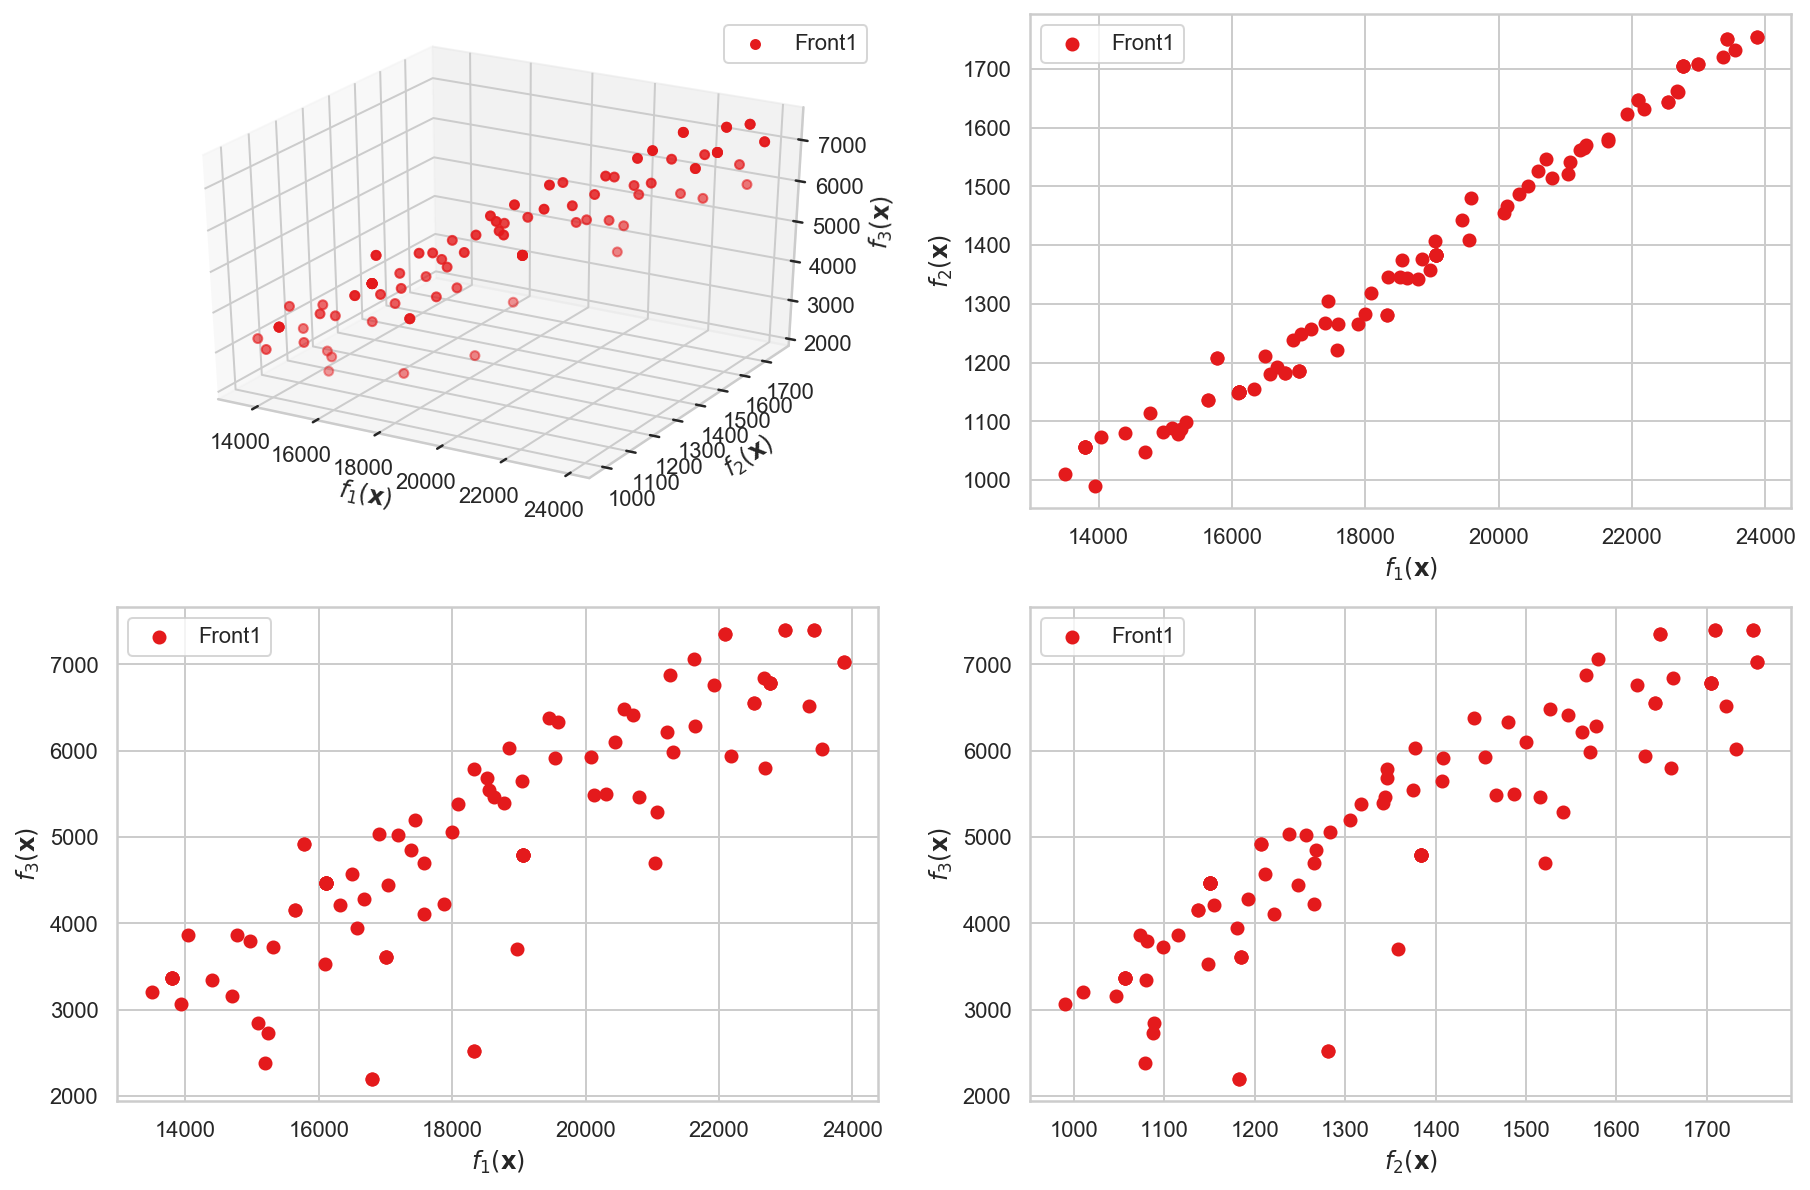

In [34]:
#file_name, m, pop_size, num_gen, mut_rate, xover_rate
instance = instance_create('jeu_100_25_1.txt', 3, 100, 100, .05, .8, 0)
%time res, logbook, fronts, stats = execute_EA(instance, verbose = True)

In [35]:
stats

{'instance_name': 'r_100_25_1',
 'sample_num': None,
 'xover_rate': 0.8,
 'mut_rate': 0.05,
 'pop_size': 100,
 'num_gen': 100,
 'n_kp': 3,
 'mean_f1': 18562.63959479016,
 'median_f1': 18425.0,
 'variance_f1': 8688658.867953734,
 'sample_size': 100,
 'min_f1': 13496.0,
 'max_f1': 23869.0,
 'mean_f2': 1356.13,
 'median_f2': 1343.0,
 'variance_f2': 50067.01310000001,
 'min_f2': 990,
 'max_f2': 1755,
 'mean_f3': 5020.28,
 'median_f3': 4886.5,
 'variance_f3': 1922374.1816000005,
 'min_f3': 2199,
 'max_f3': 7401}